<a href="https://colab.research.google.com/github/Nannanpeng/Treaty_Game/blob/master/Treaty_length_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Data simulation for treaty game
## <center> ---- model for treaty length
## There are several conclusions from this simlutaion.
* Assuming that treaty lengh follows a geometric distribution. Both geometric and exponential model can help recover the ture parameter and detect the treatment effects.
* If there are heterogeneities in a treatment, geometric and exponential model can still detect the treatment effects but not the true parameters.
* A poisson model does not work well in both cases.
* A mixture model is not a good choice for this simulated data for two reasons. There are just 200 simulated data points for each treatment. Also, the difference between the two treatments is not that big (just 0.05) or the data is very close to each other in the two treatments. If the two problems can be solved. A mixture model might work well. PS: I have played with different parameters and found this. There are also some hints in this post https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html.
* Based on what I did, I think we need at least 150-200 data points for each treatment if we want our analysis to work. 

In [ ]:
!pip install --upgrade https://github.com/pymc-devs/pymc3/archive/refs/tags/v3.11.2.zip
!pip install --upgrade https://github.com/arviz-devs/arviz/archive/refs/tags/v0.11.2.zip

     | 2.8MB 4.1MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pymc3: filename=pymc3-3.11.2-cp37-none-any.whl size=869394 sha256=f51985386dbc440ed57476735c13ea1ad8b6c999c2302981f608ceeaf2e26566
  Stored in directory: /tmp/pip-ephem-wheel-cache-q6u5k_um/wheels/6d/3c/75/5c9e4681eb3dee81809c6364790509515e5353c501a8936880
Successfully built pymc3
  Found existing installation: pymc3 3.11.2
    Uninstalling pymc3-3.11.2:
      Successfully uninstalled pymc3-3.11.2
     | 6.5MB 4.3MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for arviz: filename=arviz-0.11.2-cp37-none-any.whl size=1550841 sha256=6185f59a32c67e98ddcc57b5e6b5f8d51aa4d5abd7f9f5832c61a147ee6d9d36
  Stored in directory: /tmp/pip-ephem-wheel-cache-6v7mm789/wheels/66/4f/09/41f2c5590114884286aee620e0fa7d42928bcca34a6e57742b
Success

In [ ]:
from scipy.stats import geom, norm
from scipy.special import expit
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc3.distributions.transforms as tr

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.11.2


In [ ]:
np.random.seed(12345) 

## Data generation
1). Pure distribution

In [ ]:
n = 200   # number of data points for each treatment
prob_annuity_ending = 0.2
prob_lumpsum_ending = 0.15
noises = norm.rvs(0, 0.001, size=n)

annuity_treaty_length = geom.rvs(prob_annuity_ending + noises)
lumpsum_treaty_length = geom.rvs(prob_lumpsum_ending + noises)
treaty_len = np.concatenate((annuity_treaty_length, lumpsum_treaty_length))
institute = [1]*n + [0]*n

pure_sim_data = pd.DataFrame(zip(treaty_len, institute), columns=['TreatyLength', 'Institute'])

In [ ]:
pure_sim_data

,TreatyLength,Institute
0,2,1
1,8,1
2,1,1
3,6,1
4,12,1
...,...,...
395,10,0
396,9,0
397,2,0
398,8,0


2). Mixture distribution

In [ ]:
n = 200   # number of data points for each treatment
prob_annuity_ending_1, prob_annuity_ending_2 = 0.3, 0.1
prob_lumpsum_ending_1, prob_lumpsum_ending_2 = 0.25, 0.05

noises = norm.rvs(0, 0.001, size=n//2)
annuity_prob = list(prob_annuity_ending_1 + noises) + list(prob_annuity_ending_2 + noises)
annuity_treaty_length = geom.rvs(annuity_prob)

lumpsum_prob = list(prob_lumpsum_ending_1 + noises) + list(prob_lumpsum_ending_2 + noises)
lumpsum_treaty_length = geom.rvs(lumpsum_prob)

treaty_len = np.concatenate((annuity_treaty_length, lumpsum_treaty_length))
institute = [1]*n + [0]*n

mix_sim_data = pd.DataFrame(zip(treaty_len, institute), columns=['TreatyLength', 'Institute'])

In [ ]:
mix_sim_data

,TreatyLength,Institute
0,2,1
1,7,1
2,7,1
3,4,1
4,1,1
...,...,...
395,40,0
396,33,0
397,42,0
398,31,0


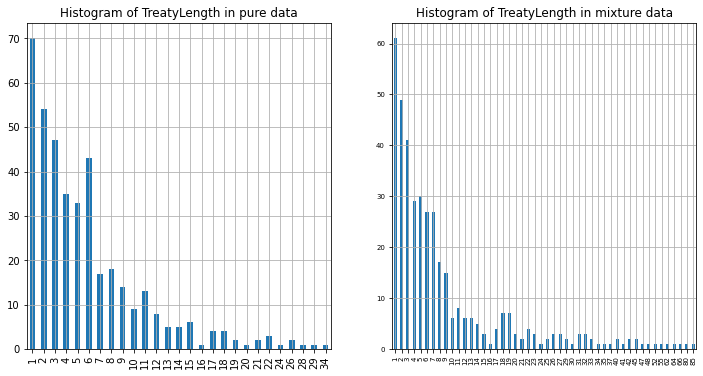

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pure = pure_sim_data['TreatyLength'].value_counts().sort_index()
pure.plot(kind='bar', title='Histogram of TreatyLength in pure data', grid=True, ax=ax1, fontsize=10)

mix = mix_sim_data['TreatyLength'].value_counts().sort_index()
mix.plot(kind='bar', title='Histogram of TreatyLength in mixture data', grid=True, ax=ax2, fontsize=7);

## Simulation (Pymc 3)

## 1). Geometric model
A. Pure data

In [ ]:
def GeometricModel(data):
    with pm.Model() as model:
        betas = pm.Normal('betas', 0, 20, shape=2)
        p = 1/(1 + np.exp(-(betas[0] + betas[1] * data['Institute'])))
        obs = pm.Geometric('obs', p, observed=data['TreatyLength'])
        trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
    return trace, model

In [ ]:
trace_1, model_1 = GeometricModel(pure_sim_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.


In [ ]:
res1 = pm.summary(trace_1)
res1

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-1.750,0.080,-1.897,-1.600,0.002,0.002,1246.0,1675.0,1.0
betas[1],0.415,0.115,0.186,0.615,0.003,0.002,1380.0,1596.0,1.0


In [ ]:
print('The geometric probability for lump_sum is: {:.3f}.'.format(expit(res1.iloc[0,0])))
print('The geometric probability for annuity is: {:.3f}.'.format(expit(res1.iloc[0,0] + res1.iloc[1,0])))

The geometric probability for lump_sum is: 0.148.
The geometric probability for annuity is: 0.208.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


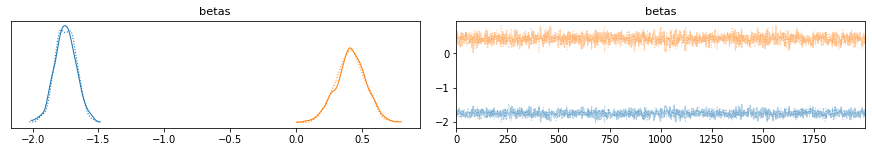

In [ ]:
pm.traceplot(trace_1);

The geometric model fits the data well. It can correctly recover the parameters.


B. Mixture data

In [ ]:
trace_1_mix, model_1_mix = GeometricModel(mix_sim_data)

In [ ]:
res1_mix = pm.summary(trace_1_mix)
res1_mix

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],-2.440,0.074,-2.591,-2.311,0.002,0.002,1215.0,1212.0,1215.0,1809.0,1.0
betas[1],0.652,0.108,0.460,0.861,0.003,0.002,1496.0,1469.0,1483.0,1804.0,1.0


In [ ]:
print('The geometric probability for lump_sum is: {:.3f}.'.format(expit(res1_mix.iloc[0,0])))
print('The geometric probability for annuity is: {:.3f}.'.format(expit(res1_mix.iloc[0,0] + res1_mix.iloc[1,0])))

The geometric probability for lump_sum is: 0.080.
The geometric probability for annuity is: 0.143.


For mixture data, the geometric model can still figure out the treatment effects.

## 2). Exponential model
A. Pure data

In [ ]:
def ExponentialModel(data):
    with pm.Model() as model:
        betas = pm.Uniform('betas', 0, 5, shape=2)
        lam = betas[0] + betas[1] * data['Institute']
        obs = pm.Exponential('obs', lam, observed=data['TreatyLength'])
        trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
    return trace, model

In [ ]:
trace_2, model_2 = ExponentialModel(pure_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1027.45draws/s]


In [ ]:
pm.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],0.153,0.012,0.131,0.175,0.000,0.0,1226.0,1226.0,1220.0,1257.0,1.0
betas[1],0.065,0.020,0.028,0.100,0.001,0.0,1363.0,1363.0,1352.0,1371.0,1.0


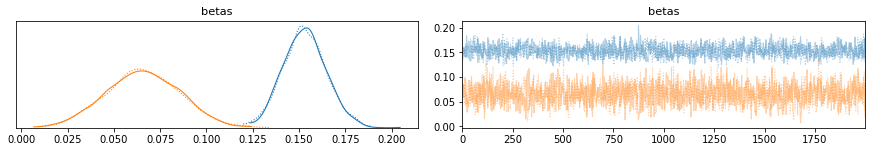

In [ ]:
pm.traceplot(trace_2);

The exponential model fits the pure data well, though the data is generated through a geometric process.

B. Mixture data

In [ ]:
trace_2_mix, model_2_mix = ExponentialModel(mix_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1033.92draws/s]


In [ ]:
pm.summary(trace_2_mix)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],0.081,0.006,0.070,0.092,0.0,0.0,1907.0,1907.0,1898.0,1576.0,1.0
betas[1],0.063,0.012,0.042,0.086,0.0,0.0,2193.0,2193.0,2186.0,2297.0,1.0


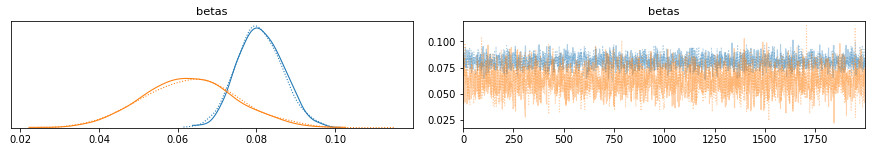

In [ ]:
pm.traceplot(trace_2_mix);

For mixture data, the exponential model can detect the treatment effects as well.

## 3). Poisson model
A. Pure data

In [ ]:
def PoissonModel(data):
    with pm.Model() as model:
        betas = pm.Normal('betas', 0, 10, shape=2)
        lam = pm.math.exp(betas[0] + betas[1] * data['Institute'])
        obs = pm.Poisson('obs', lam, observed=data['TreatyLength'])
        trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
    return trace, model

In [ ]:
trace_3, model_3 = PoissonModel(pure_sim_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.


In [ ]:
pm.summary(trace_3)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],1.912,0.028,1.858,1.963,0.001,0.000,1564.0,2117.0,1.0
betas[1],-0.344,0.043,-0.427,-0.264,0.001,0.001,1489.0,2084.0,1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


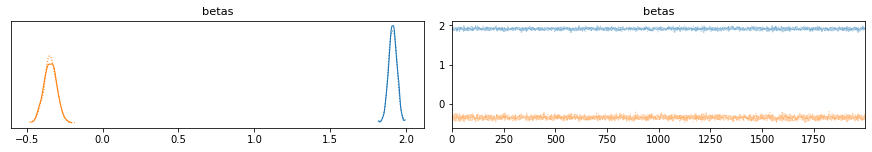

In [ ]:
pm.traceplot(trace_3);

The model fit is not vert good and it is hard to see the treatment effects.

B. Mixture data

In [ ]:
trace_3_mix, model_3_mix = PoissonModel(mix_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 2 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1081.16draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
pm.summary(trace_3_mix)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],4.997,0.004,4.990,5.000,0.000,0.000,3030.0,3029.0,2033.0,1681.0,1.0
betas[1],1.996,0.186,1.637,2.336,0.004,0.002,2794.0,2788.0,2787.0,2365.0,1.0


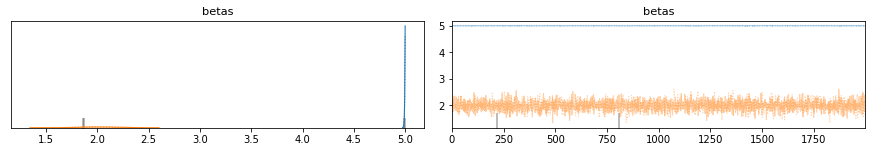

In [ ]:
pm.traceplot(trace_3_mix);

For the mixture data, a poisson model can detect the treatment effects.

## 4). Mixture model

In [ ]:
def MixtureModel(data):
    with pm.Model() as model:
        betas = pm.Normal('betas', 0, 10, shape=2, transform=tr.ordered, testval=[0.1, 0.5])
        prob_0 = 1/(1 + np.exp(-betas[0]))
        prob_1 = 1/(1 + np.exp(-betas[1]))
        geo_0 = pm.Geometric.dist(prob_0)
        geo_1 = pm.Geometric.dist(prob_1)
        w = pm.Dirichlet('weights', a=np.array([1, 1]))
        like = pm.Mixture('like', w=w, comp_dists = [geo_0, geo_1], observed=data['TreatyLength'])
        trace = pm.sample(4000, tune=1000, chains=2, cores=1)
    return trace, model

In [ ]:
trace_4, model_4 = MixtureModel(pure_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [weights, betas]
Sampling chain 1, 39 divergences: 100%|██████████| 5000/5000 [00:22<00:00, 218.73it/s]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7106120620857695, but should be close to 0.8. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6954145003977417, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
res_2 = pm.summary(trace_4)
res_2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],-1.659,0.129,-1.913,-1.456,0.009,0.006,229.0,215.0,283.0,158.0,1.0
betas[1],1.892,5.232,-1.625,13.068,0.164,0.116,1018.0,1018.0,760.0,1915.0,1.0
weights[0],0.747,0.235,0.307,1.000,0.011,0.008,481.0,430.0,582.0,1357.0,1.0
weights[1],0.253,0.235,0.000,0.693,0.011,0.008,481.0,481.0,582.0,1357.0,1.0


In [ ]:
print('The probability in the first geometric distribution is: {:.3f}.'.format(1/(1 + np.exp(-res_2.iloc[0,0]))))
print('The probability in the second geometric distribution is: {:.3f}.'.format(1/(1 + np.exp(-res_2.iloc[0,1]))))

The probability in the first geometric distribution is: 0.160.
The probability in the second geometric distribution is: 0.532.


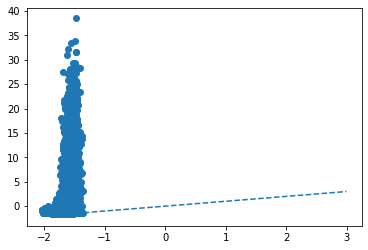

In [ ]:
x = trace_4['betas']  # see the constraint from the samples
plt.scatter(x[:,0], x[:,1])
plt.plot([-2,3],[-2,3], '--');

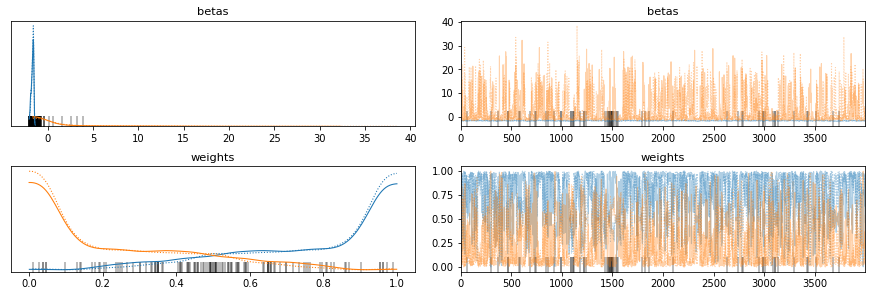

In [ ]:
pm.traceplot(trace_4);

This mixture model does not fit the model well.


## 5) Negative-binomial model (added)
Check if a negative-binomial model can fit the gemotric-simulated data

In [ ]:
def logistic(beta):
    return 1.0 / (1. + np.exp(beta))

def NegativeBinomialModel(data):
    with pm.Model() as model:
        betas = pm.Normal('betas', 0, 10, shape=2)
        #n = pm.Poisson(1, shape=2)
        #betas = pm.HalfCauchy('betas', 0, 10, shape=4)
        p = pm.Deterministic('logistic transform', 1/(1+pm.math.exp(betas[0] + betas[1] * data['Institute'])))
        #p = 1/(1+pm.math.exp(betas[0] + betas[1] * data['Institute']))
        obs = pm.NegativeBinomial('obs', p=p, n=1, observed=data['TreatyLength'])
        trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
    return trace, model

In [ ]:
trace_5, model_5 = NegativeBinomialModel(pure_sim_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.


In [ ]:
res_5 = pm.summary(trace_5)
res_5

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],1.913,0.075,1.773,2.055,0.002,0.002,1269.0,1893.0,1.0
betas[1],-0.342,0.111,-0.549,-0.127,0.003,0.002,1405.0,2033.0,1.0
logistic transform[0],0.172,0.011,0.152,0.194,0.000,0.000,2536.0,2868.0,1.0
logistic transform[1],0.172,0.011,0.152,0.194,0.000,0.000,2536.0,2868.0,1.0
logistic transform[2],0.172,0.011,0.152,0.194,0.000,0.000,2536.0,2868.0,1.0
...,...,...,...,...,...,...,...,...,...
logistic transform[395],0.129,0.008,0.114,0.145,0.000,0.000,1269.0,1893.0,1.0
logistic transform[396],0.129,0.008,0.114,0.145,0.000,0.000,1269.0,1893.0,1.0
logistic transform[397],0.129,0.008,0.114,0.145,0.000,0.000,1269.0,1893.0,1.0
logistic transform[398],0.129,0.008,0.114,0.145,0.000,0.000,1269.0,1893.0,1.0


In [ ]:
1/(1+np.exp(res_5['mean'][0])), 1/(1+np.exp(res_5['mean'][0] + res_5['mean'][1]  ))

(0.12864419274420597, 0.17207388055243097)

# <center> Data from the lab (discussion)---Treaty length simulation

### 1. What infomation do we have or what does the lab data look like?
#### Consider a single environment, say lump-sum treaty sysytem

In [ ]:
np.random.seed(1234)
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [ ]:
colnames = ['SubID', 'Role', 'Match', 'TreatyLength', 'TreatyEndingReason', 'LandSplit', 'Payment']
n_matchs = 2; n_treaty = 4; n_sub = 2
n_obs = n_matchs * n_treaty 
tot_obs = n_obs * n_obs

SubID = np.repeat([101, 102], n_obs)
Role = np.repeat(['Settler', 'Native'], n_obs)
Match = np.tile(np.repeat(['Match'+str(i+1) for i in range(n_matchs)], n_treaty), n_sub)

TreatyLength = np.random.randint(1, 7, tot_obs)
EndingReason = np.random.choice(['SettlerEnding', 'NativeEnding'], tot_obs)

LandSplit = np.concatenate((np.random.randint(55, 80, n_obs),
                            np.random.randint(30, 50, n_obs)))
Payment = np.random.randint(200, 300, tot_obs)

In [ ]:
data = zip(SubID, 
           Role, 
           Match, 
           TreatyLength,
           EndingReason,
           LandSplit,
           Payment)
sample = pd.DataFrame(data=data, columns=colnames)
for i in range(n_matchs*n_sub-1):
    n = np.random.randint(1, 4)
    sample.loc[(i*4+n):((i+1)*4-1), 'TreatyLength'] = np.nan
for i in range(n_treaty):
    sample.iloc[i, 3:] = sample.iloc[8+i, 3:]

sample.loc[sample.TreatyLength.isnull(), ['TreatyEndingReason', 'LandSplit', 'Payment']] = np.nan

In [ ]:
sample

,SubID,Role,Match,TreatyLength,TreatyEndingReason,LandSplit,Payment
0,101,Settler,Match1,3,NativeEnding,42,272
1,101,Settler,Match1,4,NativeEnding,39,202
2,101,Settler,Match1,5,NativeEnding,43,216
3,101,Settler,Match1,nan,NaN,nan,nan
4,101,Settler,Match2,1,SettlerEnding,64,244
5,101,Settler,Match2,2,SettlerEnding,56,224
6,101,Settler,Match2,nan,NaN,nan,nan
7,101,Settler,Match2,nan,NaN,nan,nan
8,102,Native,Match1,3,NativeEnding,42,272
9,102,Native,Match1,4,NativeEnding,39,202


In [ ]:
sample = sample.dropna().reset_index(drop=True)
sample

,SubID,Role,Match,TreatyLength,TreatyEndingReason,LandSplit,Payment
0,101,Settler,Match1,3,NativeEnding,42,272
1,101,Settler,Match1,4,NativeEnding,39,202
2,101,Settler,Match1,5,NativeEnding,43,216
3,101,Settler,Match2,1,SettlerEnding,64,244
4,101,Settler,Match2,2,SettlerEnding,56,224
5,102,Native,Match1,3,NativeEnding,42,272
6,102,Native,Match1,4,NativeEnding,39,202
7,102,Native,Match1,5,NativeEnding,43,216
8,102,Native,Match2,3,NativeEnding,30,279
9,102,Native,Match2,3,SettlerEnding,34,267


#### Notice there is replicated data in some sense. A treaty will show up in the observation of both players. $\textbf{What should we do when analyzing treaty lengh?}$ 

Maybe we can drop the treaty length data beloning to these who didn't break the treaty. This is becase the treaty length is determined by subjects who break it, not by these who choose to stay put.

In [ ]:
def highlight_match1(d):
    if d.Match == 'Match1':
        return ['background-color: yellow']*d.shape[0]
    else:
        return ['background-color: white']*d.shape[0]

sample.style.apply(highlight_match1, axis=1)

,SubID,Role,Match,TreatyLength,TreatyEndingReason,LandSplit,Payment
0,101,Settler,Match1,3,NativeEnding,42,272
1,101,Settler,Match1,4,NativeEnding,39,202
2,101,Settler,Match1,5,NativeEnding,43,216
3,101,Settler,Match2,1,SettlerEnding,64,244
4,101,Settler,Match2,2,SettlerEnding,56,224
5,102,Native,Match1,3,NativeEnding,42,272
6,102,Native,Match1,4,NativeEnding,39,202
7,102,Native,Match1,5,NativeEnding,43,216
8,102,Native,Match2,3,NativeEnding,30,279
9,102,Native,Match2,3,SettlerEnding,34,267


In [ ]:
sample.loc[sample.Role.str[0] == sample.TreatyEndingReason.str[0], ]

,SubID,Role,Match,TreatyLength,TreatyEndingReason,LandSplit,Payment
3,101,Settler,Match2,1,SettlerEnding,64,244
4,101,Settler,Match2,2,SettlerEnding,56,224
5,102,Native,Match1,3,NativeEnding,42,272
6,102,Native,Match1,4,NativeEnding,39,202
7,102,Native,Match1,5,NativeEnding,43,216
8,102,Native,Match2,3,NativeEnding,30,279
11,102,Native,Match2,1,NativeEnding,30,298


### What does the lab data look like after this consideration?
Let's leave variables Landsplit and Payment in a side. 

In [ ]:
n_sub = 4; n_matchs = 4; n_treaty = 4
n_obs = n_sub * n_matchs
SubID = np.repeat([101, 102, 103, 104], n_matchs)
Role = np.repeat(['Settler', 'Native', 'Settler', 'Native'], n_matchs)
Match = np.tile(['Match'+str(i+1) for i in range(n_matchs)], n_sub)
Institution = np.repeat(['Annuity', 'LumpSum'], n_obs/2)

TreatyLength = np.random.randint(1, 7, size=(n_obs, n_treaty))

In [ ]:
d1 = pd.DataFrame(zip(SubID, Role, Match, Institution), columns=['SubID', 'Role', 'Match', 'Institution'])
d2 = pd.DataFrame(TreatyLength, columns=['Treaty'+str(i+1) for i in range(n_treaty)])
d = pd.concat((d1, d2), axis=1)

The data set will look like a (long) panel data (think of Treaties as time since there is a learning effect). 

In [ ]:
d.set_index(['SubID', 'Match'])

Role Institution  Treaty1  Treaty2  Treaty3  Treaty4
SubID Match                                                          
101   Match1  Settler     Annuity        3        3        6        5
      Match2  Settler     Annuity        3        2        4        4
      Match3  Settler     Annuity        6        1        6        2
      Match4  Settler     Annuity        3        6        4        2
102   Match1   Native     Annuity        4        1        3        6
      Match2   Native     Annuity        1        4        6        3
      Match3   Native     Annuity        3        4        5        2
      Match4   Native     Annuity        1        5        3        3
103   Match1  Settler     LumpSum        4        2        1        6
      Match2  Settler     LumpSum        2        5        6        6
      Match3  Settler     LumpSum        4        3        5        1
      Match4  Settler     LumpSum        3        5        2        3
104   Match1   Native     LumpSum        6        5        4        6
      Match2   Native     LumpSum        4        1        6        2
      Match3   Native     LumpSum        2        2        3        3
      Match4   Native     LumpSum        2        2        2        6

In [ ]:
for i in range(n_obs):
    d.iloc[i, 5+np.random.randint(n_treaty):] = np.NaN

Unfortunately, the data set will not be a balanced panel. More likely, the data will look like this.

In [ ]:
d.drop(labels=np.random.randint(n_obs, size=4)).set_index(['SubID', 'Match'])

Role Institution  Treaty1  Treaty2  Treaty3  Treaty4
SubID Match                                                          
101   Match1  Settler     Annuity        3        3        6        5
      Match2  Settler     Annuity        3      nan      nan      nan
      Match3  Settler     Annuity        6        1        6        2
      Match4  Settler     Annuity        3        6        4        2
102   Match1   Native     Annuity        4        1        3      nan
      Match2   Native     Annuity        1        4        6        3
      Match3   Native     Annuity        3        4      nan      nan
103   Match1  Settler     LumpSum        4        2        1      nan
      Match3  Settler     LumpSum        4      nan      nan      nan
      Match4  Settler     LumpSum        3        5        2        3
104   Match1   Native     LumpSum        6        5      nan      nan
      Match3   Native     LumpSum        2        2      nan      nan
      Match4   Native     LumpSum        2        2        2        6

### What can and should we study?

* Treatment effects. Intuitively, annuity treaty will be more stable and will last longer when compared to the lump-sum treaty.
* Role effects. Different roles might hold different ability to maintain the treaty. For example, for a settler, who proposes the treaty, it's easy for her to  propose a new one when she figures out that there is more profitbale treaty for both her and her opponets. But this is not easy for a native, who might stick to the current treaty even enough she knows there is a more profitable treaty. 
* Session (match) effects. Subjects will learn how to make/recognize a 'good' treaty. Treaty will last longer as they have more experiences.
* Time effects (or treaty effects). This is a more detailed version of session effects. The assumption is that subjects will do better when they propose/accept a new treaty. In this case, we are likely to get a more balanced pandel when we line up all treaties in different matches together.
* Individual effects. The idea is that different individuals will have differing parameters to stick to a treaty. Some subjects are more easy to end the treaty early.

In [ ]:
TreatyLength = np.random.randint(1, 7, size=(3, 16))
d_line_up = pd.DataFrame(data=TreatyLength, columns=['Treaty'+str(i+1) for i in range(16)])
d_line_up.iloc[0, 12:] = np.NaN
d_line_up.iloc[1, 14:] = np.NaN
d_line_up.insert(0, 'SubID', [101, 102, 103])
d_line_up.insert(1, 'Institution', ['Annuity', 'LupSum', 'Annuity'])
d_line_up.insert(2, 'Role', ['Native', 'Settler', 'Native'])

In [ ]:
d_line_up

,SubID,Institution,Role,Treaty1,Treaty2,Treaty3,Treaty4,Treaty5,Treaty6,Treaty7,Treaty8,Treaty9,Treaty10,Treaty11,Treaty12,Treaty13,Treaty14,Treaty15,Treaty16
0,101,Annuity,Native,1,2,1,6,3,2,4,1,3,4,4,6,nan,nan,nan,nan
1,102,LupSum,Settler,4,5,6,1,3,6,3,1,6,4,6,1,4,6,nan,nan
2,103,Annuity,Native,1,4,5,4,3,3,3,3,3,1,2,2,4,4,6,1
